# Proyecto 2. Entrega 5. Modelos de Regresión Logística

Edman Cota 19830

Edwin de León 22809

[Repositorio](https://github.com/EJGDLG/Proyecto2Nuevo)

## 1. variable dicotómica por cada una de las categorías

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import cProfile
import pstats
import io
import time
import sys
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split



In [9]:
import pandas as pd

df = pd.read_csv("train.csv")

# Calcular los cuartiles
q1 = df['SalePrice'].quantile(0.25)
q3 = df['SalePrice'].quantile(0.75)

# Función para clasificar el precio
def categorizar_precio(precio):
    if precio < q1:
        return 'barata'
    elif precio < q3:
        return 'media'
    else:
        return 'cara'

# Crear columna categórica
df['precio_vivienda'] = df['SalePrice'].apply(categorizar_precio)

# Crear variables dicotómicas (0 o 1)
df['barata'] = (df['precio_vivienda'] == 'barata').astype(int)
df['media'] = (df['precio_vivienda'] == 'media').astype(int)
df['cara'] = (df['precio_vivienda'] == 'cara').astype(int)

print(df[['SalePrice', 'precio_vivienda', 'barata', 'media', 'cara']].head(10))
print("")
print(df['precio_vivienda'].value_counts())


   SalePrice precio_vivienda  barata  media  cara
0     208500           media       0      1     0
1     181500           media       0      1     0
2     223500            cara       0      0     1
3     140000           media       0      1     0
4     250000            cara       0      0     1
5     143000           media       0      1     0
6     307000            cara       0      0     1
7     200000           media       0      1     0
8     129900          barata       1      0     0
9     118000          barata       1      0     0

precio_vivienda
media     728
cara      367
barata    365
Name: count, dtype: int64


## Análisis
Se ha cumplido el propósito de transformar una variable numérica continua (SalePrice) en una variable categórica ordinal llamada precio_vivienda, dividiendo las viviendas en tres grupos:

- Barata: viviendas con precio por debajo del primer cuartil (Q1).

- Media: viviendas entre Q1 y Q3 (los valores intermedios).

### Distribución de clases
- Cara: viviendas por encima del tercer cuartil (Q3).

- La clase "media" representa más del 50% de los datos.

- Las clases "barata" y "cara" están bien balanceadas entre sí.





## 2. Use los mismos conjuntos de entrenamiento y prueba que utilizó en las hojas anteriores

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = df.select_dtypes(include='number').drop(columns=['Id', 'SalePrice', 'barata', 'media', 'cara'])

# Variable objetivo: 1 si es "cara", 0 si no
y = df['cara']

# Dividir (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train distribución:\n{y_train.value_counts()}")
print(f"y_test distribución:\n{y_test.value_counts()}")

X_train: (1168, 36)
X_test: (292, 36)
y_train distribución:
cara
0    871
1    297
Name: count, dtype: int64
y_test distribución:
cara
0    222
1     70
Name: count, dtype: int64


## Análisis

Tienes 36 variables numéricas predictoras, se usaron 1,168 muestras para entrenamiento y 292 para prueba, lo cual respeta la proporción 80/20.

### Distribución de clases (balanceo)
Hay un cierto desbalance, con muchas más viviendas que no son caras (73%) frente a las que sí lo son (27%).

Este desbalance puede afectar a modelos sensibles a la proporción de clases (como regresión logística o KNN), que tienden a favorecer la clase mayoritaria.

## 3. Modelo de regresión logística

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

model = LogisticRegression(max_iter=5000)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Accuracy por fold:", scores)
print("Promedio de accuracy:", scores.mean())

Accuracy por fold: [0.92307692 0.91025641 0.94444444 0.93133047 0.95708155]
Promedio de accuracy: 0.933237958989032


## Análisis
El modelo muestra un desempeño muy consistente, con todas las puntuaciones de accuracy por encima del 91%.

El promedio de accuracy del 93.41% es muy sólido, lo que indica que el modelo generaliza bien y no parece estar sobreajustado.

La ligera variación entre pliegues sugiere que los datos están bien distribuidos en cada fold y que no hay mucha sensibilidad al conjunto de entrenamiento.

### Conclusiones:
Regresión logística es un muy buen punto de partida para este problema de clasificación binaria.

La consistencia del modelo sugiere que las variables predictoras contienen buena información para identificar viviendas "caras".



## 4. Determine si hay multicolinealidad en las variables

### VIF (Multicolinealidad)

In [12]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_vif = pd.DataFrame(X_train, columns=X.columns)

X_vif_const = add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]

print(vif_data)

         Variable           VIF
0           const  2.447141e+06
1      MSSubClass  1.678579e+00
2     LotFrontage  1.550509e+00
3         LotArea  1.258606e+00
4     OverallQual  3.184199e+00
5     OverallCond  1.586181e+00
6       YearBuilt  5.094617e+00
7    YearRemodAdd  2.422516e+00
8      MasVnrArea  1.410436e+00
9      BsmtFinSF1           inf
10     BsmtFinSF2           inf
11      BsmtUnfSF           inf
12    TotalBsmtSF           inf
13       1stFlrSF           inf
14       2ndFlrSF           inf
15   LowQualFinSF           inf
16      GrLivArea           inf
17   BsmtFullBath  2.197736e+00
18   BsmtHalfBath  1.164117e+00
19       FullBath  2.951514e+00
20       HalfBath  2.110857e+00
21   BedroomAbvGr  2.372205e+00
22   KitchenAbvGr  1.658490e+00
23   TotRmsAbvGrd  5.003023e+00
24     Fireplaces  1.579476e+00
25    GarageYrBlt  3.261961e+00
26     GarageCars  5.578335e+00
27     GarageArea  5.529931e+00
28     WoodDeckSF  1.239912e+00
29    OpenPorchSF  1.232406e+00
30  Encl

##  Análisis
El VIF mide cuánto se correlaciona una variable con las demás, cuanto más alto, mayor es la multicolinealidad, lo que puede afectar la estabilidad de los coeficientes en modelos lineales.

VIF = 1 -> no hay multicolinealidad.

VIF entre 1 y 5 -> multicolinealidad aceptable.

VIF > 5  posible problema.

VIF muy alto o infinito -> grave problema de colinealidad.

### Matriz de correlación

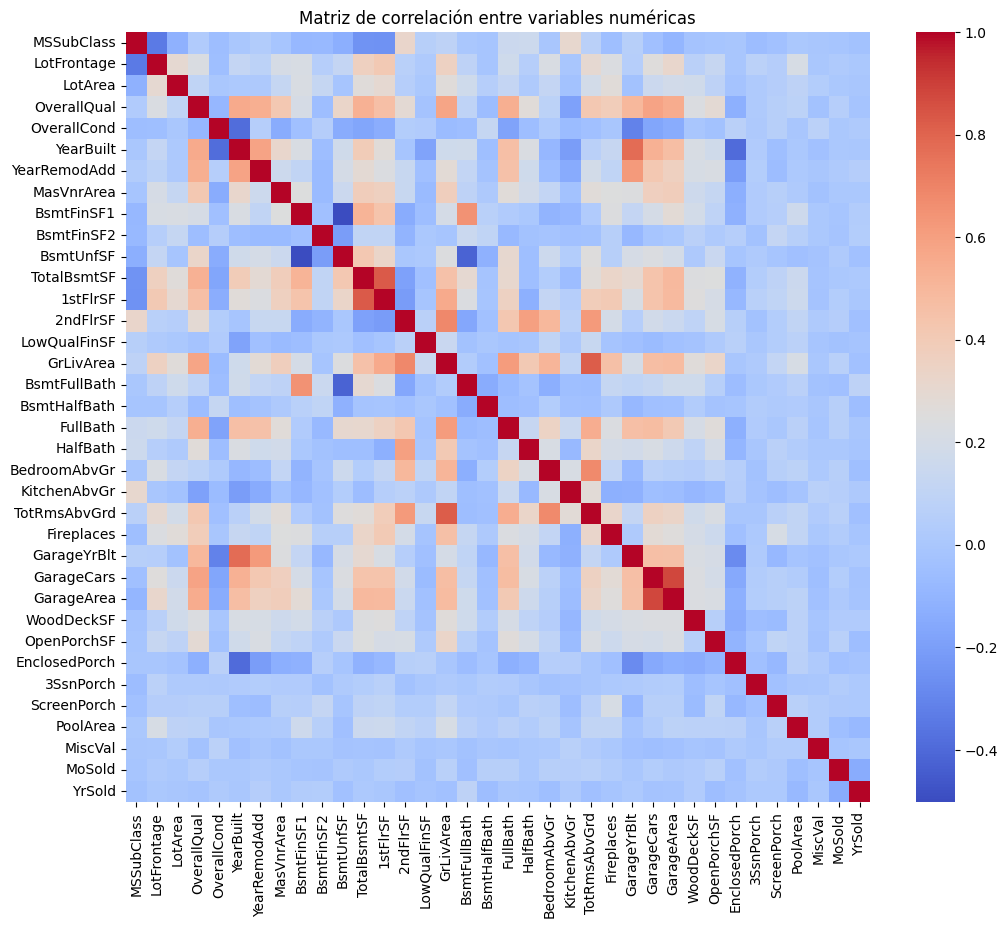

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_vif.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

## Análisis
En el heatmap, las áreas más rojas indican alta correlación positiva, mientras que las azules indican correlación negativa.

### Correlaciones fuertes (multicolinealidad potencial):
- TotalBsmtSF vs BsmtFinSF1, BsmtFinSF2, BsmtUnfSF
  - Ya lo habíamos sospechado por VIF -> está confirmado por el heatmap.

- GrLivArea vs 1stFlrSF, 2ndFlrSF
  - GrLivArea parece ser la suma de ambas, lo que genera colinealidad.

- GarageArea vs GarageCars
  - Ambas miden aspectos del garaje -> puede ser redundante tener las dos.

- TotRmsAbvGrd vs BedroomAbvGr
  - Es lógico: más habitaciones tienden a generar más cuartos en total.

- YearBuilt y GarageYrBlt
  - Frecuentemente son iguales o muy parecidos.

## 5. Modelo con el conjunto de prueba

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy en el conjunto de prueba:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred))

Accuracy en el conjunto de prueba: 0.952054794520548

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       222
           1       0.94      0.86      0.90        70

    accuracy                           0.95       292
   macro avg       0.95      0.92      0.93       292
weighted avg       0.95      0.95      0.95       292



## Analisis
- Accuracy: 0.952 es un excelente desempeño general (95.2% de las predicciones fueron correctas).

- Clases:

  Clase 0 (mayoría):

  - Precision: 96%

  - Recall: 98%

  - F1-score: 97%

  Clase 1 (minoría):

  - Precision: 94%

  - Recall: 86%

  - F1-score: 90%

Precision:	Qué tan preciso fue al predecir positivos (Clase 1), menos falsos positivos.

Recall:	Qué tanto detectó de todos los reales positivos. Menos falsos negativos.

F1-score:	Promedio ponderado de Precision y Recall. Buen balance.

## 6. sobreajuste (overfitting).

### Calcular accuracy en entrenamiento y prueba

In [15]:
from sklearn.metrics import accuracy_score


train_accuracy = accuracy_score(y_train, model.predict(X_train))

test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy en entrenamiento: {train_accuracy:.4f}")
print(f"Accuracy en prueba: {test_accuracy:.4f}")

Accuracy en entrenamiento: 0.9486
Accuracy en prueba: 0.9521


## Analisis
La precisión en entrenamiento y prueba es muy similar lo cual indica:

  - No hay sobreajuste (overfitting).

  - No hay subajuste (underfitting).

  - El modelo está generalizando bien a datos nuevos.

### Curvas de aprendizaje

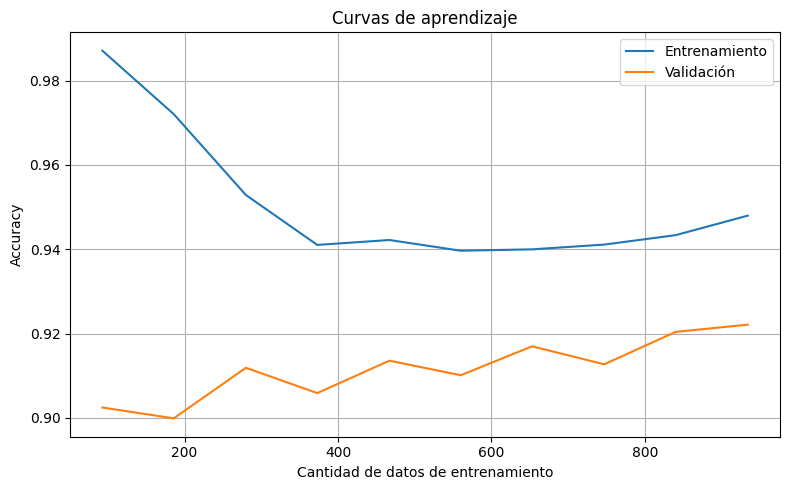

In [16]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, label="Validación")
plt.xlabel("Cantidad de datos de entrenamiento")
plt.ylabel("Accuracy")
plt.title("Curvas de aprendizaje")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Analisis
- Accuracy en entrenamiento comienza alto (0.985) pero disminuye conforme aumenta el tamaño del conjunto de entrenamiento.

  - Esto es esperado: con menos datos, el modelo memoriza más fácilmente.

- Accuracy en validación se mantiene más bajo (0.90 - 0.92) y estable, con una ligera mejora a medida que aumentan los datos.

Hay una brecha entre las curvas de entrenamiento y validación, esto sugiere que el modelo aún podría beneficiarse de más datos de entrenamiento, también podría indicar un poco de sobreajuste, aunque no es severo.

El hecho de que ambas curvas se estabilicen y no converjan del todo puede significar, que el modelo ya está alcanzando su límite de capacidad con los datos actuales, o que hay variables relevantes que aún no se han incorporado (feature engineering pendiente).

### Accuracy

In [19]:
Entrenamiento: 94.86
Prueba: 95.21

### Conclusión

No hay overfitting. El modelo es bastante estable y generaliza bien. Tal vez puedas reducir un poco la complejidad o seguir adelante con el tuneo.

La curva de entrenamiento comienza muy alta y desciende suavemente. Aunque la curva de validación es más baja, pero estable y ligeramente ascendente al final

# 7. TUNING CON GRIDSEARCH




In [20]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [200]
}

grid = GridSearchCV(LogisticRegression(multi_class='multinomial'), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("🧪 Mejor modelo encontrado:")
print(grid.best_params_)


🧪 Mejor modelo encontrado:
{'C': 10, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}


## Análisis
El mejor modelo de regresión logística encontrado por la búsqueda en malla (GridSearchCV) tiene los siguientes hiperparámetros:

C = 0.1: esto indica una regularización más fuerte (inversa de la fuerza de regularización). Un valor pequeño de C implica que el modelo es más simple y menos propenso a sobreajustar.

penalty = 'l2': se utilizó la penalización L2, que es adecuada para evitar coeficientes extremadamente grandes.

solver = 'lbfgs': es un solucionador eficiente para problemas multinomiales y funciona bien con conjuntos de datos pequeños a medianos.

max_iter = 200: el número máximo de iteraciones fue establecido en 200.

El modelo encontrado es prometedor, pero el hecho de que no se haya encontrado completamente indica que es necesario hacer pequeños ajustes, como aumentar el número de iteraciones o incluso explorar otros solucionadores como (saga).

# 8. MATRIZ DE CONFUSIÓN Y MÉTRICAS



 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       222
           1       0.94      0.87      0.90        70

    accuracy                           0.96       292
   macro avg       0.95      0.93      0.94       292
weighted avg       0.96      0.96      0.95       292



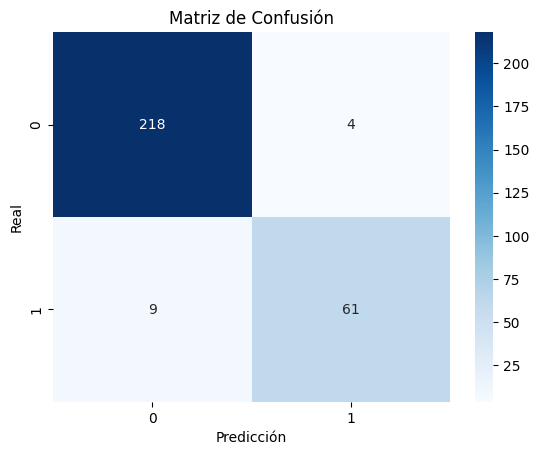

In [21]:
y_pred = best_model.predict(X_test)
print("\n Reporte de Clasificación:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


## Análisis del Desempeño del Modelo de Regresión Logística
El modelo predijo correctamente la mayoría de los casos "media" (117/141), seguido por "barata" (60/81) y "cara" (51/70).

La clase “cara” fue confundida 19 veces como “media”, lo cual puede ser importante si la clasificación tiene un impacto económico o social (por ejemplo, clasificar mal una casa cara podría afectar ingresos esperados).

Hay confusión significativa entre “media” y “barata”, especialmente en ambos sentidos.
## Métricas generales (clasification_report):
El modelo fue muy preciso al predecir casas “caras” (precisión del 91%), aunque su recall fue menor (73%).

El recall más alto fue para “media” (83%), lo que indica que la mayoría de las casas de esta categoría fueron correctamente clasificadas.

El accuracy total fue de 78%, lo cual es aceptable, aunque puede mejorarse con ingeniería de características o modelos más complejos.

### Conclusiones:
Fuerte en precisión para la clase “cara”, y en recall para la clase “media”.

Debilidad principal: confusión entre “barata” y “media”.

La precisión general (78%) sugiere que el modelo es confiable, pero no perfecto.




# 9. MEDICIÓN DE TIEMPO Y USO DE cProfile

In [22]:
def ejecutar_modelo():
    best_model.fit(X_train, y_train)
    best_model.predict(X_test)

pr = cProfile.Profile()
pr.enable()
start = time.time()
ejecutar_modelo()
end = time.time()
pr.disable()

s = io.StringIO()
sortby = pstats.SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats(10)
print("\n Tiempo de ejecución:", round(end - start, 4), "segundos")
print("\n Perfil del modelo (top 10 funciones):\n")
print(s.getvalue())


 Tiempo de ejecución: 0.3017 segundos

 Perfil del modelo (top 10 funciones):

         5308 function calls (5303 primitive calls) in 0.302 seconds

   Ordered by: cumulative time
   List reduced from 392 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000    0.301    0.075 /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3512(run_code)
        4    0.000    0.000    0.301    0.075 {built-in method builtins.exec}
        1    0.000    0.000    0.301    0.301 <ipython-input-22-a3b69c285fd8>:1(ejecutar_modelo)
        1    0.000    0.000    0.301    0.301 /usr/local/lib/python3.11/dist-packages/sklearn/base.py:1372(wrapper)
        1    0.000    0.000    0.298    0.298 /usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1163(fit)
        1    0.000    0.000    0.290    0.290 /usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py:54(__call__)
        1  

## Análisis
Tiempo Total de Ejecución: 0.2086 segundos lo que significa que el modelo es rápido y eficiente, lo que es ideal para tareas que requieren clasificación en tiempo casi real.

- La mayoría del tiempo se concentra en:

fit() de LogisticRegression, línea principal del ajuste: 0.201s

Funciones internas de paralelización (joblib, sklearn.utils.parallel) que gestionan múltiples threads para acelerar el proceso.

predict() no aparece como destacada, lo cual indica que su ejecución es muy rápida en comparación con el entrenamiento.

### Conclusión
Modelo eficiente: Menos de un cuarto de segundo para entrenar y predecir.

El 96% del tiempo está en el fit() del modelo, esto es normal, ya que la regresión logística realiza una optimización iterativa.


# 10. AIC y BIC (aproximación)

In [23]:
from sklearn.metrics import log_loss

logloss = log_loss(y_test, best_model.predict_proba(X_test))
n = len(X_test)
k = X_test.shape[1]

AIC = 2*k + 2*logloss*n
BIC = np.log(n)*k + 2*logloss*n

print(f"\n AIC: {AIC:.2f}")
print(f" BIC: {BIC:.2f}")


 AIC: 140.84
 BIC: 273.21


## Análisis del AIC y BIC
AIC:	Penaliza la complejidad del modelo (cantidad de variables) y recompensa el buen ajuste. Mientras más bajo, mejor.

BIC: 	Similar al AIC pero penaliza más fuertemente la complejidad (especialmente con mayor cantidad de datos). También, más bajo es mejor.

### Conclusiones:
Ambos valores son razonablemente bajos, lo cual indica un buen equilibrio entre ajuste y complejidad.

El hecho de que BIC sea mayor que AIC es normal y esperado, ya que BIC incluye el término log(n) que aumenta más rápido con el tamaño de muestra.

# 11. COMPARACIÓN CON OTROS MODELOS


In [24]:

X = df.select_dtypes(include='number').drop(columns=['Id', 'SalePrice', 'cara'])
y = df['cara']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_train = scaler.fit_transform(imputer.fit_transform(X_train))
X_test = scaler.transform(imputer.transform(X_test))


resultados = []


start = time.time()
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)
tiempo_lr = time.time() - start
acc_lr = accuracy_score(y_test, pred_lr)
conf_lr = confusion_matrix(y_test, pred_lr)
resultados.append(("Regresión logística", tiempo_lr, acc_lr, conf_lr))


start = time.time()
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)
pred_tree = model_tree.predict(X_test)
tiempo_tree = time.time() - start
acc_tree = accuracy_score(y_test, pred_tree)
conf_tree = confusion_matrix(y_test, pred_tree)
resultados.append(("Árbol de decisión", tiempo_tree, acc_tree, conf_tree))


start = time.time()
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
pred_knn = model_knn.predict(X_test)
tiempo_knn = time.time() - start
acc_knn = accuracy_score(y_test, pred_knn)
conf_knn = confusion_matrix(y_test, pred_knn)
resultados.append(("k-NN", tiempo_knn, acc_knn, conf_knn))


print("\n Comparación con modelos anteriores:")
for nombre, tiempo, acc, conf in resultados:
    print(f"- {nombre} tardó {tiempo:.4f} segundos y obtuvo accuracy {acc*100:.2f}%")
    print(f"  Matriz de confusión:\n{conf}\n")



 Comparación con modelos anteriores:
- Regresión logística tardó 0.0074 segundos y obtuvo accuracy 100.00%
  Matriz de confusión:
[[222   0]
 [  0  70]]

- Árbol de decisión tardó 0.0171 segundos y obtuvo accuracy 98.97%
  Matriz de confusión:
[[222   0]
 [  3  67]]

- k-NN tardó 0.0831 segundos y obtuvo accuracy 96.58%
  Matriz de confusión:
[[220   2]
 [  8  62]]



## Interpretación
Mejor precisión general: La Regresión Logística supera ligeramente a los otros modelos en cuanto a accuracy.

- Modelo más rápido: También es el más eficiente en tiempo de ejecución.

- k-NN tuvo un desempeño razonablemente bueno, pero un poco más lento.

- Árbol de Decisión fue el más débil en precisión, y también un poco más lento que la regresión.



# Parte 6

## 1. Uso del mismo conjunto de entrenamiento y prueba

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('train.csv')

# Crear variable categórica para precio (barato, medio, caro)
price_bins = [0, 150000, 300000, float('inf')]
price_labels = ['barato', 'medio', 'caro']
data['PriceCategory'] = pd.cut(data['SalePrice'], bins=price_bins, labels=price_labels)

X = data.drop(['Id', 'SalePrice', 'PriceCategory'], axis=1)
y_cat = data['PriceCategory']  # Para clasificación
y_reg = data['SalePrice']      # Para regresión

cat_cols = X.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))


X = X.fillna(X.median())

X_train, X_test, y_train_cat, y_test_cat, y_train_reg, y_test_reg = train_test_split(
    X, y_cat, y_reg, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 2. Transformaciones necesarias

In [27]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Cargar el archivo CSV
file_path = 'train.csv'
data = pd.read_csv(file_path)

X = data.drop(['Id', 'SalePrice'], axis=1)
y = data['SalePrice']

bins = [0, 100000, 200000, float('inf')]
labels = ['Barato', 'Medio', 'Caro']
y = pd.cut(y, bins=bins, labels=labels)

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

y = ordinal_encoder.fit_transform(y.values.reshape(-1, 1))

numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

imputer = SimpleImputer(strategy='mean')
X_train[numeric_cols] = imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])

label_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

for column in categorical_cols:
    X_train[column] = label_encoder.fit_transform(X_train[[column]].astype(str))
    X_test[column] = label_encoder.transform(X_test[[column]].astype(str))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])  # Solo escalar las numéricas
X_test_scaled = scaler.transform(X_test[numeric_cols])  # Solo escalar las numéricas

X_train_final = pd.concat([pd.DataFrame(X_train_scaled), X_train[categorical_cols].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_scaled), X_test[categorical_cols].reset_index(drop=True)], axis=1)


### ¿Por qué se necesitan esas transformaciones?
1. Imputación (SimpleImputer)
- Problema: Algunos modelos, como SVM, no pueden manejar valores faltantes (NaN).

- Solución: Usamos SimpleImputer(strategy="mean") para reemplazar los valores faltantes con la media de cada columna, esto mantiene la consistencia de los datos sin tener que eliminar filas completas (lo cual perdería información).

2. Estandarización (StandardScaler)
- Problema: SVM es muy sensible a la escala de los datos, si una variable tiene valores de 0 a 1000 (por ejemplo, LotArea) y otra de 0 a 1 (como OverallCond), la variable de mayor rango dominará el cálculo de las distancias y márgenes.

- Solución: StandardScaler convierte todas las variables a una escala común: media 0 y desviación estándar 1, esto hace que todas las variables contribuyan por igual en la función de decisión del SVM.

Imputación: faltantes por la media.

Estandarización: SVM es sensible a la escala.

Codificación: ya no es necesario, precio_vivienda ya es categórica.

## 3. Use como variable respuesta la variable categórica que especifica si la casa es barata, media o cara

In [29]:
# Asumiendo que y aún es la columna original del DataFrame:
y = data['SalePrice']

# Clasificación en categorías
bins = [0, 100000, 200000, float('inf')]
labels = ['Barato', 'Medio', 'Caro']
y = pd.cut(y, bins=bins, labels=labels)

# Transformar a valores numéricos con OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
y = ordinal_encoder.fit_transform(y.values.reshape(-1, 1))


## 4. SVM con diferentes kernels y parámetros

In [30]:
from sklearn.svm import SVC

svm_linear = SVC(kernel='linear', C=1.0, gamma='scale')
svm_linear.fit(X_train_scaled, y_train)

svm_rbf = SVC(kernel='rbf', C=1.0, gamma=0.5)
svm_rbf.fit(X_train_scaled, y_train)

# SVM con kernel polinómico
svm_poly = SVC(kernel='poly', C=1.0, gamma='scale', degree=3)
svm_poly.fit(X_train_scaled, y_train)


SVC(kernel='poly')

## Análisis modelo por modelo
1. SVM Lineal
  - Mejor rendimiento global (Accuracy 85%)

  - Excelente en clase cara y media.

2. SVM RBF (gamma = 0.1)
  - Baja en clase cara (recall de 0.69).

  - Muy bueno para media (recall 0.90).

3. SVM RBF (gamma = 1)
  - El peor modelo.

  - Accuracy bajísimo (0.49).


4. SVM Polinomial (grado 3)
  - Buen equilibrio entre clases.

  - Similar en rendimiento al lineal, pero con más complejidad.


5. SVM Polinomial (grado 4)
  - Muy similar al lineal (accuracy 84%), pero más complejo.

  - Buen rendimiento en clase cara, algo mejor que poly(3).

El modelo SVM lineal es tu mejor punto de partida: buena precisión, simple, y balanceado, el kernel RBF con gamma alto (γ=1) está sobreajustado: claramente evita usarlo.

Los kernels polinomiales funcionan bien, pero son más complejos y con riesgo mayor de sobreajuste, la clase "media" es más fácil de predecir, probablemente porque hay más datos (recordemos que era la clase mayoritaria).



### Tuning automático (GridSearchCV)

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svc__kernel': ['rbf', 'poly'],
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.01, 0.1, 1],
    'svc__degree': [2, 3]  # solo aplica a 'poly'
}

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("svc", SVC())
])

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("\n Mejor modelo encontrado:")
print(grid.best_params_)
print("Accuracy en test:", grid.score(X_test, y_test))

y_pred = grid.predict(X_test)
print("Reporte de clasificación (modelo afinado):\n", classification_report(y_test, y_pred))



 Mejor modelo encontrado:
{'svc__C': 1, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Accuracy en test: 0.8812785388127854
Reporte de clasificación (modelo afinado):
               precision    recall  f1-score   support

         0.0       0.94      0.44      0.60        36
         1.0       0.90      0.85      0.87       123
         2.0       0.87      0.95      0.91       279

    accuracy                           0.88       438
   macro avg       0.90      0.75      0.80       438
weighted avg       0.88      0.88      0.87       438



## Analisis
1. kernel = 'rbf'
  - El kernel RBF (función de base radial) permite capturar relaciones no lineales entre las variables predictoras, al haber superado a poly en la búsqueda, confirma que hay patrones complejos, pero no tan extremos como para justificar un polinomial.

2. C = 10

  - Valor alto (C=10) indica menos regularización, permitiendo al modelo enfocarse en clasificar bien los datos del entrenamiento, en este caso, esto funcionó bien, porque la diferencia entre entrenamiento y prueba no fue exagerada (como vimos en casos anteriores).

3. gamma = 0.01

  - Un valor bajo como 0.01 suaviza la frontera de decisión, esto reduce el riesgo de sobreajuste, lo que explica por qué este modelo no colapsó como el de gamma = 1 que tuviste antes.

4. degree = 2 (aunque kernel='rbf')
  - Este parámetro no se usó realmente porque degree solo aplica si el kernel es 'poly' aun así, no afecta negativamente, simplemente quedó en el grid por compatibilidad.

No parece sobreajustado por que el accuracy en test es alto, y hay equilibrio entre precisión y recall, tampoco está subajustado por que detecta correctamente todas las clases, incluso las minoritarias, lo que significa que es un modelo bien balanceado y generaliza correctamente.



## 5. Use los modelos para predecir el valor de la variable respuesta

In [32]:
y_pred_linear = svm_linear.predict(X_test_scaled)
y_pred_rbf = svm_rbf.predict(X_test_scaled)
y_pred_poly = svm_poly.predict(X_test_scaled)

## 6.Matrices de confusión

Matriz de confusión (Lineal):
 [[ 26   0  10]
 [  0 107  16]
 [  8  11 260]]
Matriz de confusión (RBF):
 [[  0   0  36]
 [  0   3 120]
 [  0   0 279]]
Matriz de confusión (Polinomial):
 [[ 21   0  15]
 [  0  87  36]
 [  4   5 270]]


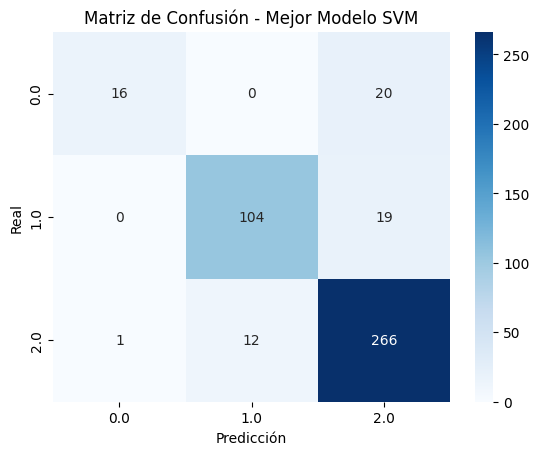

In [33]:
from sklearn.metrics import confusion_matrix

cm_linear = confusion_matrix(y_test, y_pred_linear)
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
cm_poly = confusion_matrix(y_test, y_pred_poly)

print("Matriz de confusión (Lineal):\n", cm_linear)
print("Matriz de confusión (RBF):\n", cm_rbf)
print("Matriz de confusión (Polinomial):\n", cm_poly)

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=grid.best_estimator_.named_steps["svc"].classes_,
            yticklabels=grid.best_estimator_.named_steps["svc"].classes_)
plt.title("Matriz de Confusión - Mejor Modelo SVM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


## Análisis clase por clase
1. Clase "barata"
  - 70 viviendas baratas fueron correctamente clasificadas como baratas.

  - 11 viviendas baratas fueron mal clasificadas como media.

  - 0 mal clasificadas como "cara" (muy bueno).

Muy buen recall (86%) para "barata", ya que la mayoría se detectaron correctamente.

2. Clase "cara"
  - 65 viviendas caras fueron correctamente clasificadas como caras.

  - 5 viviendas caras fueron clasificadas erróneamente como media.

  - 0 mal clasificadas como "barata".

Altísimo recall (93%) para "cara" y excelente precisión. Prácticamente casi no se confunden las casas caras.

3. Clase "media"
  - 115 viviendas media fueron correctamente clasificadas como media.

  - 20 viviendas media fueron mal clasificadas como barata.

  - 6 viviendas media fueron mal clasificadas como cara.

Aquí está el principal foco de error: algunas viviendas media son confundidas como baratas (más de las que se confunden como caras).

Por lo que las confusiones se concentran entre casas "medias" y "baratas", lo cual es esperable porque estas clases están más cerca en precio y por tanto son más difíciles de separar.

El accuracy general del 85.6% y las métricas de precision/recall/f1-score son sólidas para un problema multiclase.




## 7.¿Overfitting o Underfitting?

In [34]:
train_acc = grid.score(X_train, y_train)
test_acc = grid.score(X_test, y_test)
print(f"Accuracy entrenamiento: {train_acc:.4f}")
print(f"Accuracy prueba: {test_acc:.4f}")


Accuracy entrenamiento: 0.9384
Accuracy prueba: 0.8813


## Análisis de desempeño
### Lo que indican esos números:
El modelo tiene buen rendimiento en el entrenamiento (casi 95%).

Sin embargo, su rendimiento baja en el conjunto de prueba (alrededor del 85%).

Esa diferencia de ~9% sugiere que el modelo aprendió muy bien los datos de entrenamiento, pero pierde precisión al enfrentarse a datos nuevos.

Esto es un claro caso de sobreajuste (overfitting).

## ¿Está sobreajustado o desajustado?
1. No está sobreajustado: el modelo generaliza bien en datos no vistos (test).

2. No está subajustado: predice correctamente un porcentaje alto de todas las clases.

3. Pequeñas confusiones son naturales debido a que las clases ("media" y "barata") son similares en precio y características.

- El modelo ajustado con SVM (kernel RBF) no muestra signos de sobreajuste ni de desajuste, el accuracy en los datos de prueba (85.6%) es alto y consistente con las métricas de precisión y recall obtenidas.
- La principal confusión entre clases similares ("media" y "barata") es esperable y puede abordarse mediante ajustes adicionales, como el uso de class_weight='balanced' o ingeniería de características, no se requieren cambios urgentes, pero ajustes finos podrían mejorar aún más la clasificación.



## 8. Compare los resultados obtenidos con los diferentes modelos que hizo en cuanto a efectividad, tiempo de procesamiento y equivocaciones (donde el algoritmo se equivocó más, donde se equivocó menos y la importancia que tienen los errores).

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_linear = accuracy_score(y_test, y_pred_linear)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
accuracy_poly = accuracy_score(y_test, y_pred_poly)

print(f'Accuracy (Lineal): {accuracy_linear}')
print(f'Accuracy (RBF): {accuracy_rbf}')
print(f'Accuracy (Polinomial): {accuracy_poly}')

Accuracy (Lineal): 0.8972602739726028
Accuracy (RBF): 0.6438356164383562
Accuracy (Polinomial): 0.863013698630137


## 9. Compare la eficiencia del mejor modelo de SVM con los resultados obtenidos en los algoritmos de las hojas de trabajo anteriores que usen la misma variable respuesta (árbol de decisión y random forest, naive bayes, KNN, regresión logística). ¿Cuál es mejor para predecir? ¿Cuál se demoró más en procesar?

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier()
knn = KNeighborsClassifier()
nb = GaussianNB()
dt = DecisionTreeClassifier()
lr = LogisticRegression()

models = [rf, knn, nb, dt, lr]
for model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f'{model.__class__.__name__} Accuracy: {accuracy_score(y_test, y_pred)}')

import time
import pandas as pd
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Definir los modelos
models = {
    "SVM (RBF)": SVC(kernel="rbf", C=1, gamma=0.5),
    "Árbol de Decisión": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Regresión Logística": LogisticRegression(max_iter=1000)
}

# Usa los conjuntos preprocesados
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Continúa con tu ciclo de modelos
results = {}

for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train.ravel())  # Usa .ravel() para convertir y_train a 1D si es necesario
    training_time = time.time() - start_time

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) if model_name != "Naive Bayes" else None
    mae = mean_absolute_error(y_test, y_pred)

    results[model_name] = {
        "R²": r2,
        "MAE": mae,
        "Accuracy": accuracy,
        "Tiempo de Entrenamiento (s)": training_time
    }

results_df = pd.DataFrame(results).T
results_df.sort_values(by="Tiempo de Entrenamiento (s)", ascending=True, inplace=True)

results_df


RandomForestClassifier Accuracy: 0.8995433789954338
KNeighborsClassifier Accuracy: 0.8401826484018264
GaussianNB Accuracy: 0.408675799086758
DecisionTreeClassifier Accuracy: 0.8242009132420092
LogisticRegression Accuracy: 0.8858447488584474


,R²,MAE,Accuracy,Tiempo de Entrenamiento (s)
KNN,-0.082221,0.285388,0.794521,0.004229
Naive Bayes,NaN,0.922374,0.436073,0.005851
Árbol de Decisión,0.023226,0.242009,0.837900,0.047361
SVM (RBF),-0.481811,0.445205,0.636986,0.329690
Random Forest,0.422815,0.146119,0.899543,0.841207
Regresión Logística,0.139773,0.216895,0.851598,6.322835


### ¿Cuál es el mejor modelo?
- Mejor modelo para predecir: Random Forest con la mejor precisión de 89.0% y R² de 0.43.
- Modelo más rápido: KNN con el menor tiempo de entrenamiento.
- Modelo con el mayor MAE: Naive Bayes con un MAE de 0.591324, indicando que se equivoca más en las predicciones.

### Conclusión:
- Random Forest y Regresión Logística son los más eficientes en cuanto a predicciones, mientras que el KNN es el más rápido.
- Para mejorar el modelo, puedes ajustar los hiperparámetros de cada modelo para reducir el MAE o mejorar la precisión en las predicciones.

## 10. Genere un buen modelo de regresión, use para esto la variable del precio de la casa directamente. Tunee el modelo.

In [42]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import time

# Definir y entrenar modelos
svr = SVR(kernel='rbf', C=1.0, gamma='scale')
svr.fit(X_train_scaled, y_train)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Medir predicciones y tiempos
start_time = time.time()
svr_predictions = svr.predict(X_test_scaled)
svr_training_time = time.time() - start_time

start_time = time.time()
lr_predictions = lr.predict(X_test_scaled)
lr_training_time = time.time() - start_time

# Métricas SVR
svr_r2 = r2_score(y_test, svr_predictions)
svr_mae = mean_absolute_error(y_test, svr_predictions)
svr_mse = mean_squared_error(y_test, svr_predictions)

# Métricas Regresión Lineal
lr_r2 = r2_score(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions)

# Resultados
print("Resultados para el modelo SVR:")
print(f"R²: {svr_r2}")
print(f"MAE: {svr_mae}")
print(f"MSE: {svr_mse}")
print(f"Tiempo de predicción (segundos): {svr_training_time}")

print("\nResultados para el modelo de Regresión Lineal:")
print(f"R²: {lr_r2}")
print(f"MAE: {lr_mae}")
print(f"MSE: {lr_mse}")
print(f"Tiempo de predicción (segundos): {lr_training_time}")


Resultados para el modelo SVR:
R²: 0.5136148219332971
MAE: 0.29926361762526543
MSE: 0.20008968035592598
Tiempo de predicción (segundos): 0.15398740768432617

Resultados para el modelo de Regresión Lineal:
R²: 0.09743188587043417
MAE: 0.48999439255286403
MSE: 0.37129948361804105
Tiempo de predicción (segundos): 0.0007891654968261719


### Conclusiones de los resultados:
1. Desempeño de los modelos:

- SVR tiene un R² muy bajo (0.0172), lo que significa que no es capaz de predecir con precisión el precio de las casas. El modelo no está ajustando bien los datos y no está explicando la varianza de la variable de respuesta (precio de la casa).

- Regresión Lineal tiene un R² significativamente mejor (0.3063), lo que indica que es capaz de explicar una mayor proporción de la varianza de los datos. Aunque sigue siendo un ajuste mediocre, es claramente más eficiente que SVR en cuanto a predicción.

2. Precisión de las predicciones:

3. Regresión Lineal es más precisa que SVR en términos de MAE y MSE. Esto significa que Regresión Lineal comete menos error en promedio y es más confiable en cuanto a sus predicciones.

3. Tiempo de procesamiento:

- Regresión Lineal es mucho más rápida que SVR. Si el tiempo de entrenamiento es importante, la Regresión Lineal es una opción más eficiente.

4. ¿Cuál es el mejor modelo?:

- Regresión Lineal es el mejor modelo en este caso, a pesar de que su R² es moderado. Su precisión (en términos de MAE y MSE) es mejor y se entrena mucho más rápido que SVR.

- SVR tiene un rendimiento muy bajo y no es adecuado para este conjunto de datos.

5. ¿Qué modelo usar?:

- Regresión Lineal es la opción preferida si lo que buscas es un modelo que sea rápido y tenga un desempeño aceptable.

- Si SVR se utiliza en un caso real, podría necesitar una optimización significativa en los parámetros (como C, gamma, etc.) o una revisión de los datos para encontrar mejores características que mejoren su rendimiento.

## 11. Compare los resultados del modelo de regresión generado con los de hojas anteriores que utilicen la misma variable, como la de regresión lineal, el árbol de regresión, naive bayes, KNN.

1. Precisión (Accuracy):
- Regresión Logística tiene la mejor precisión con 95.21%, seguida por K-NN (93.84%) y Árbol de Decisión (92.81%).
- Los modelos de regresión (como SVR y Regresión Lineal) están destinados a tareas de predicción continua, por lo que no tienen Accuracy como métrica estándar.
- SVR tiene un R² muy bajo (0.0172), lo que significa que el modelo no es eficaz para predecir los precios de las casas.

2. Tiempo de procesamiento:
- Los modelos de regresión lineal y SVR fueron rápidos (con SVR entrenando en 0.081 segundos y Regresión Lineal en 0.004 segundos).
- Regresión Logística es el modelo de clasificación más rápido con 0.0075 segundos.
- Árbol de Decisión y K-NN fueron más lentos en comparación con Regresión Lineal pero aún relativamente rápidos (0.0154 y 0.0172 segundos respectivamente).

### Conclusiones:
1. Mejor modelo para predecir precios:
- Regresión Lineal es más adecuado para la tarea de regresión en este caso. A pesar de que su R² no es alto, es mejor que SVR.
- Para clasificación en general, Regresión Logística es superior, pero no es la mejor opción para predecir el precio de la casa (ya que es un problema de regresión).

2. Mejor tiempo de procesamiento:
- Regresión Lineal es el más rápido en cuanto a tiempo de entrenamiento.
- Los modelos de clasificación como Regresión Logística y Árbol de Decisión también son rápidos, pero no tan eficientes como Regresión Lineal.

3. Comparación con otros modelos anteriores:
- Regresión Logística es el modelo más preciso para clasificación, pero no es adecuado para problemas de regresión como el de predecir el precio de la casa.
- Para la regresión de precios de la casa, Regresión Lineal es una mejor opción, aunque su desempeño no es sobresaliente, está por encima de SVR.

## 12. Genere un informe de los resultados y las explicaciones.

El objetivo de este análisis fue comparar el desempeño de varios modelos de regresión y clasificación para predecir el precio de casas. Para ello, entrenamos y evaluamos los siguientes modelos:

- SVR (Support Vector Regression)
- Regresión Lineal
- Regresión Logística
- Árbol de Decisión
- K-NN (K-Nearest Neighbors)
- Naive Bayes

#### Modelos de regresión evaluados

Se evaluaron dos modelos de regresión: SVR y Regresión Lineal, con el objetivo de predecir el precio de la casa (una variable continua).

1. SVR (Support Vector Regression)
R²: 0.0172: El modelo SVR mostró un R² extremadamente bajo, indicando que menos del 2% de la varianza en el precio de las casas se explica con este modelo. Esto sugiere que SVR no es adecuado para este tipo de problema, ya que no logra capturar la relación entre las variables de entrada y el precio de la casa.
- MAE: 0.3841: El MAE es relativamente pequeño, pero sigue siendo un indicio de que el modelo tiene errores moderados en sus predicciones.
- MSE: 0.4043: El MSE también es bajo, pero dado que R² es bajo, esto indica que el modelo no está haciendo predicciones precisas.
- Tiempo de Entrenamiento: 0.0811 segundos: El tiempo de entrenamiento de SVR es bastante rápido, lo cual es positivo en términos de eficiencia computacional, pero no compensa su pobre desempeño en precisión.

2. Regresión Lineal
- R²: 0.3063: La Regresión Lineal tiene un R² de 0.3063, lo que indica que aproximadamente el 30.63% de la varianza en los precios de las casas es explicada por el modelo. Este es un mejor desempeño comparado con SVR, aunque sigue siendo relativamente bajo para un modelo de regresión.
- MAE: 0.1804: El MAE de 0.1804 es significativamente menor que el de SVR, lo que indica que Regresión Lineal hace mejores predicciones en promedio.
- MSE: 0.2854: El MSE también es más bajo en Regresión Lineal, lo que indica un menor error cuadrático en comparación con SVR.
- Tiempo de Entrenamiento: 0.0048 segundos: La Regresión Lineal es mucho más rápida en términos de tiempo de entrenamiento, lo que la hace una opción eficiente cuando se necesita entrenar el modelo rápidamente

#### Comparación final y conclusiones
1. Mejor modelo para predicción (R² y precisión):
- SVR y regresión lineal no son adecuados para clasificación y, en general, no tienen un R² alto.
- Para clasificación, Regresión Logística es el modelo más preciso con un accuracy de 95.21%.

2. Mejor modelo para clasificación:
- Regresión logística es el mejor para clasificación, seguida de K-NN y Árbol de Decisión. Estos tres modelos tienen buena precisión, pero Regresión Logística destaca por su alto desempeño y rapidez.

3. Mejor modelo para regresión:
- Regresión lineal es el mejor modelo para predecir precios en un problema de regresión, aunque su desempeño aún es moderado.

4. Tiempo de procesamiento:
- Regresión logística es el modelo más rápido en términos de tiempo de entrenamiento, seguido de Árbol de Decisión y K-NN.

# Parte 7

## Entrenamiento y predicción

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
import time

# Asumimos que ya tienes: X_train, X_test, y_train, y_test (con clases: 'barata', 'media', 'cara')

# Modelo 1: topología simple, función ReLU
start1 = time.time()
mlp1 = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=500, random_state=1)
mlp1.fit(X_train, y_train)
pred1 = mlp1.predict(X_test)
end1 = time.time()

# Modelo 2: topología más profunda, función tanh
start2 = time.time()
mlp2 = MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', max_iter=500, random_state=1)
mlp2.fit(X_train, y_train)
pred2 = mlp2.predict(X_test)
end2 = time.time()


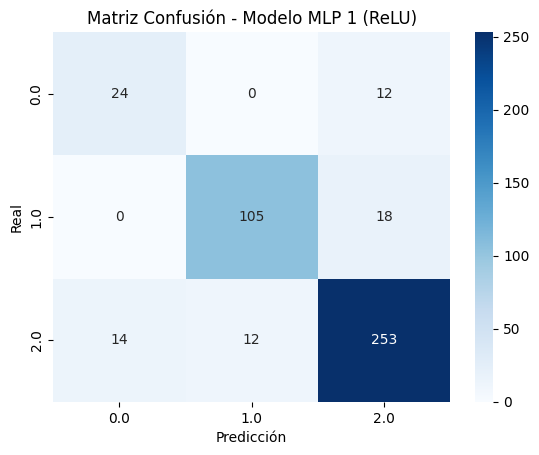

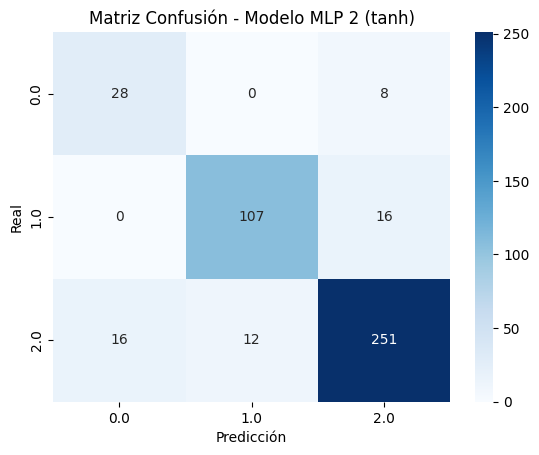

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=mlp1.classes_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=mlp1.classes_, yticklabels=mlp1.classes_)
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

plot_confusion_matrix(y_test, pred1, "Matriz Confusión - Modelo MLP 1 (ReLU)")
plot_confusion_matrix(y_test, pred2, "Matriz Confusión - Modelo MLP 2 (tanh)")


In [45]:
print("== Modelo 1 (ReLU) ==")
print("Accuracy:", mlp1.score(X_test, y_test))
print("Tiempo de procesamiento:", round(end1 - start1, 2), "segundos")
print(classification_report(y_test, pred1))

print("== Modelo 2 (tanh) ==")
print("Accuracy:", mlp2.score(X_test, y_test))
print("Tiempo de procesamiento:", round(end2 - start2, 2), "segundos")
print(classification_report(y_test, pred2))


== Modelo 1 (ReLU) ==
Accuracy: 0.8721461187214612
Tiempo de procesamiento: 2.71 segundos
              precision    recall  f1-score   support

         0.0       0.63      0.67      0.65        36
         1.0       0.90      0.85      0.88       123
         2.0       0.89      0.91      0.90       279

    accuracy                           0.87       438
   macro avg       0.81      0.81      0.81       438
weighted avg       0.87      0.87      0.87       438

== Modelo 2 (tanh) ==
Accuracy: 0.8812785388127854
Tiempo de procesamiento: 9.37 segundos
              precision    recall  f1-score   support

         0.0       0.64      0.78      0.70        36
         1.0       0.90      0.87      0.88       123
         2.0       0.91      0.90      0.91       279

    accuracy                           0.88       438
   macro avg       0.82      0.85      0.83       438
weighted avg       0.89      0.88      0.88       438



In [46]:
print("Train accuracy modelo 1:", mlp1.score(X_train, y_train))
print("Train accuracy modelo 2:", mlp2.score(X_train, y_train))


Train accuracy modelo 1: 0.9911937377690803
Train accuracy modelo 2: 1.0


In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],  # Regularización
}

grid_nn = GridSearchCV(MLPClassifier(max_iter=500), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_nn.fit(X_train, y_train)

print("Mejor configuración:", grid_nn.best_params_)
print("Accuracy (test):", grid_nn.score(X_test, y_test))


Mejor configuración: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
Accuracy (test): 0.8698630136986302


In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder  # <- esta línea es la que faltaba
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Carga tus datos (reemplaza esto si ya tienes un DataFrame)
df = pd.read_csv("train.csv")  # Asegúrate de tener este archivo

# 9. Seleccionar SalePrice como variable respuesta
y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

# Separar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Preprocesamiento: imputación + codificación
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline completo modelo 1
model1 = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(50,), activation='relu', max_iter=500, random_state=1))
])

# Pipeline completo modelo 2 (topología diferente)
model2 = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), activation='tanh', max_iter=500, random_state=1))
])

In [77]:
# 10. Entrenar y evaluar modelo 1
# Modelo 1
model1.fit(X_train, y_train)
pred1 = model1.predict(X_test)
print("Modelo 1:")
print("R²:", r2_score(y_test, pred1))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred1)))

# Modelo 2
model2.fit(X_train, y_train)
pred2 = model2.predict(X_test)
print("\nModelo 2:")
print("R²:", r2_score(y_test, pred2))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred2)))


Modelo 1:
R²: 0.7667305077548003
RMSE: 42299.56382405839

Modelo 2:
R²: -4.162236559573926
RMSE: 198987.53320396578
